In [13]:

import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd
import os
from dask.diagnostics import ProgressBar
import dask

from pismragis.analysis import sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.stats import run_stats

In [6]:
data_dir = "/import/c1/ICESHEET/ICESHEET/pism-greenland/paleo/"
exp = {"Experiment": "climate-calving",
        "proj_dir": "2023_10_climate_calving_w_posterior/",
        "snap_dir": "snap",
        "processed_dir": "processed",
        "lhs": "gris_paleo_climate_calving_w_posterior_lhs_20",
        "DEM": "GRIMP"
    }

s_dir = os.path.join(data_dir, exp["proj_dir"], exp["snap_dir"])

snap_files = sorted(glob(os.path.join(s_dir, f"""*gris_ext_g*00m_*{exp["DEM"]}_id_*-24999*.nc""")))


In [7]:
with xr.open_mfdataset(snap_files, combine="nested", concat_dim="id", parallel=True) as ds:
    print(ds)

<xarray.Dataset>
Dimensions:                                      (id: 12, time: 1, x: 180,
                                                  y: 301, z: 401, x_lc: 717,
                                                  y_lc: 1201, zb: 21,
                                                  deposition_time: 26)
Coordinates:
  * time                                         (time) object -24999-01-01 0...
  * x                                            (x) float64 -9.606e+05 ... 1...
  * y                                            (y) float64 -3.954e+06 ... -...
    lat                                          (y, x) float64 dask.array<chunksize=(301, 180), meta=np.ndarray>
    lon                                          (y, x) float64 dask.array<chunksize=(301, 180), meta=np.ndarray>
  * z                                            (z) float64 0.0 3.148 ... 5e+03
  * x_lc                                         (x_lc) float64 -4.183e+06 .....
  * y_lc                                    

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 4 dimensions

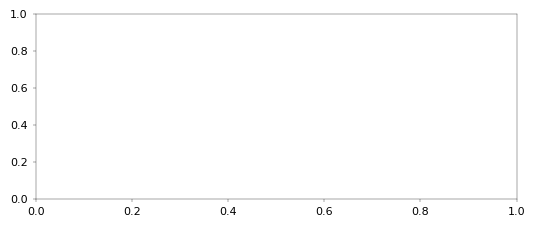

In [8]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)


In [16]:
median = dask.delayed(ds["isochronal_layer_thickness"].median(dim="id"))
with ProgressBar():
    results = median.compute()

[########################################] | 100% Completed | 2.52 sms


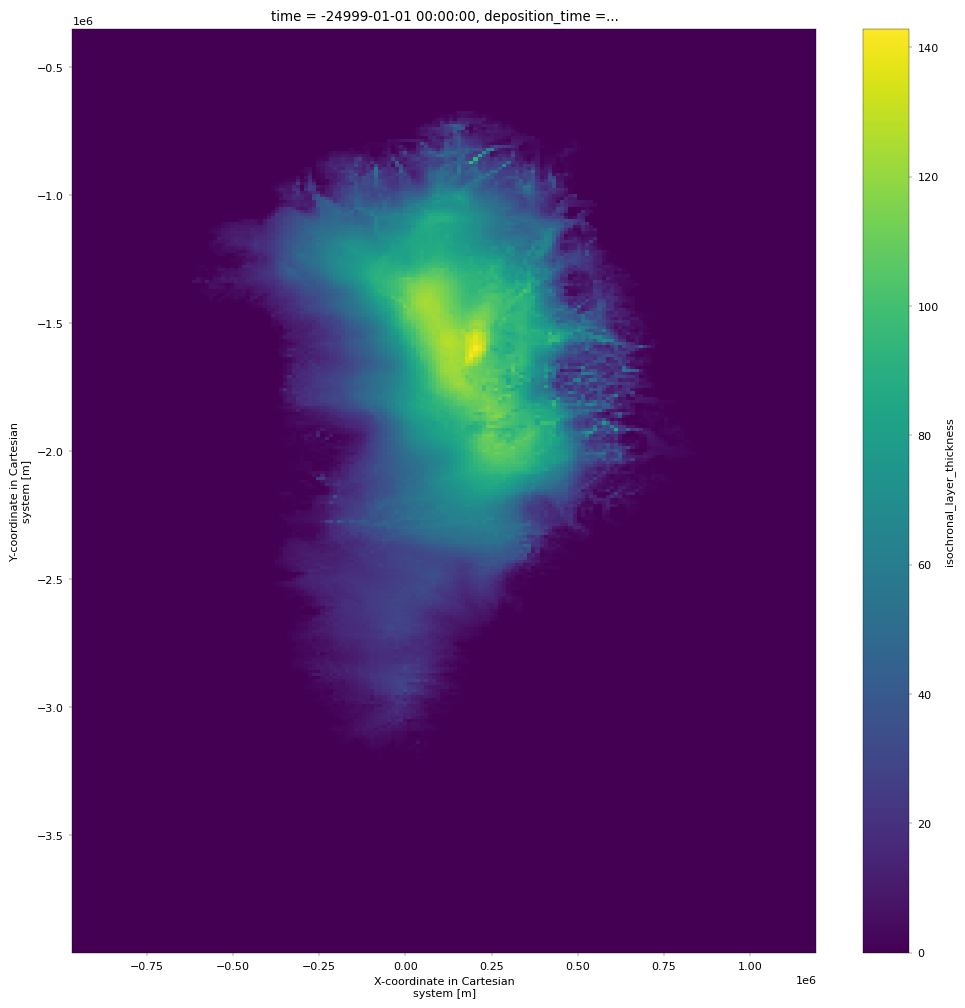

In [24]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)
results[0,:,:,10].plot(ax=ax)

-------------------------------------------



Processing date: 100%|██████████| 203/203 [00:11<00:00, 16.96it/s]

Program finished in 12 seconds


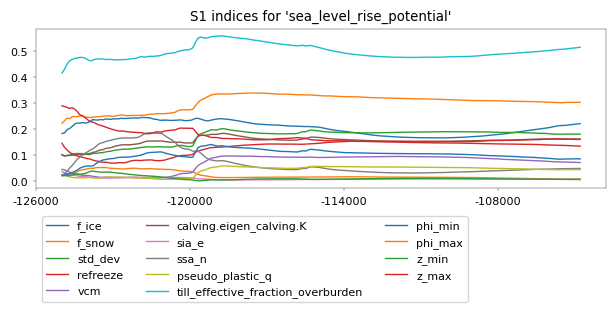

In [46]:
    si = "S1"
    outfile = f"""test.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 5.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         ds.time,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [40]:
ds["sea_level_rise_potential"][9, :].values

array([7.28421489, 7.28537764, 7.28637919, ...,        nan,        nan,
              nan])

In [51]:
calib_ds = xr.open_dataset("../calibration/2023_10_init_ragis_tillwat/state/gris_g600m_v2023_RAGIS_id_BAYES-MEDIAN_0_25_mass_transport_failed.nc")

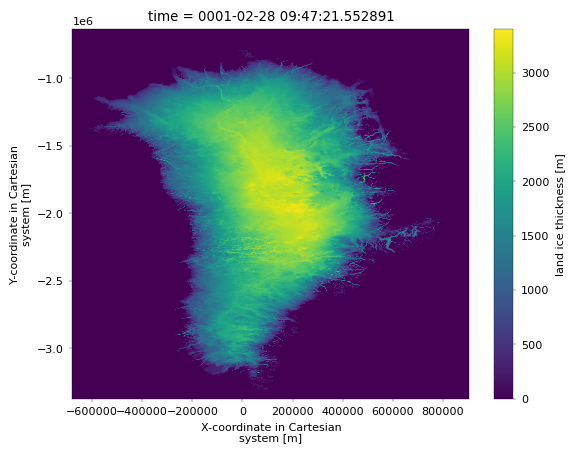

In [52]:
calib_ds["thk"].plot()

In [53]:
calib_ds["thk"].max()

<xarray.DataArray 'thk' ()>
array(3401.79741577)